# Comparison of additional constructs to external data - 10kb resolution

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from glob import glob
from scipy.signal import gaussian, fftconvolve
from matplotlib import gridspec
from scipy import signal
from scipy import stats

import sys
sys.path.append('../../combining_all_data/bin/')
sys.path.append('../bin/')
from preimplantation_toolkit import *
import preimplantation_load_data as ld

rs = np.random.RandomState()
rs.seed(42)

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

FIGOUTDIR = '../output/figures/4_Preimplantation.other_constructs.part1.comparison_to_ChIPseq_10kb/'

In [3]:
! mkdir -p $FIGOUTDIR || true;

In [4]:
HOME = '/Users/f.rang/surfdrive/Kind/data/'

BINSIZE = 10000
MINMAP_PER_KB = 1
MINMAP = int(MINMAP_PER_KB * BINSIZE / 1000)

ANNOFN = '../../combining_all_data/metadata/FR230814.samplesheet.tsv'
COLORFN = '../colors/manuscript_colors.tsv'

COUNTS = '../../combining_all_data/data/damid_counts/FR230814.DamID.sample_counts.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
BINARY = '../../combining_all_data/data/damid_binary/FR230814.DamID.sample_smooth_binary.{construct}.all_stages.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
CONTFC = '../../combining_all_data/data/damid_CF/FR230814.DamID.contact_frequency.{construct}.{stage}.{treatment}.{genotype}.damid_pass.binsize_{binsize:d}.hdf5'
INSILICO = '../../combining_all_data/data/damid_insilico/FR230814.DamID.insilico_counts.{construct}.{stage}.{treatment}.{genotype}.{sample}_samples.damid_pass.binsize_{binsize:d}.hdf5'

MAPFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.bowtie2_very_sensitive_N1.readlength_65.counts.pos.hdf5"
POSFN = HOME + "references/mouse/mm10/mappability/Mus_musculus.GRCm38.dna.primary_assembly.with_ERCC.GATC.posarray.hdf5"

# 1. Loading Kind data

In [5]:
color_dict = ld.load_color_dict(COLORFN)

## Loading samplesheet

In [6]:
chrom_order = [str(c) for c in range(1,20)] + ['X', 'Y']

In [7]:
anno = pd.read_csv(ANNOFN, sep='\t', dtype={'number_embryos': str})

## select samples passing quality filters
anno = anno[anno.DamID_PASS]

## select conditions of interest
anno = anno[anno['stage'] == '2cell']
anno = anno[anno['treatment'] == 'no_treatment']
anno = anno[anno.genotype == 'homozygous']
anno = anno.set_index(anno['damid_name'])
anno = anno[anno.cellcount == 1]

anno.head()

,runid,illumina_index,damid2_adapter_number,celseq2_adapter_number,cellcount,construct,fusion_construct,stage,treatment,genotype,...,nGenes,nTranscripts,nTranscripts_maternal,nTranscripts_paternal,allelic_celseq_balance,nERCC,nMito,DamID_PASS,DamID_PASS_allelic,CELseq_PASS
damid_name,,,,,,,,,,,,,,,,,,,,,
KIN1971.index03.DamID2_BC_001,KIN1971,3,1,0,1,Lmnb1,Dam-Lmnb1,2cell,no_treatment,homozygous,...,0,0,NaN,NaN,NaN,0,0,True,True,False
KIN1971.index03.DamID2_BC_009,KIN1971,3,9,0,1,Lmnb1,Dam-Lmnb1,2cell,no_treatment,homozygous,...,0,0,NaN,NaN,NaN,0,0,True,True,False
KIN1971.index03.DamID2_BC_017,KIN1971,3,17,0,1,Lmnb1,Dam-Lmnb1,2cell,no_treatment,homozygous,...,0,0,NaN,NaN,NaN,0,0,True,True,False
KIN1971.index03.DamID2_BC_025,KIN1971,3,25,0,1,Lmnb1,Dam-Lmnb1,2cell,no_treatment,homozygous,...,0,0,NaN,NaN,NaN,0,0,True,True,False
KIN1971.index03.DamID2_BC_033,KIN1971,3,33,0,1,Lmnb1,Dam-Lmnb1,2cell,no_treatment,homozygous,...,0,0,NaN,NaN,NaN,0,0,True,True,False


In [8]:
anno.groupby(['stage', 'fusion_construct']).size()

stage  fusion_construct  
2cell  Cbx1(FL)-Dam           27
       Dam-Cbx1(CD)           37
       Dam-Lmnb1             197
       Dam-aH3K27me3          30
       Dam-aH3K27me3(mut)     15
       Dam-only               77
dtype: int64

## Loading mappability

In [9]:
mapab = ld.load_mappability(POSFN, MAPFN, chrom_order, BINSIZE)

## Loading data

__DamID sample counts__

In [10]:
damid_counts = ld.load_sample_damid_counts(COUNTS, anno, BINSIZE, chrom_order)

Cbx1(FL)-Dam homozygous
Dam-Cbx1(CD) homozygous
Dam-Lmnb1 homozygous
Dam-aH3K27me3 homozygous
Dam-aH3K27me3(mut) homozygous
Dam-only homozygous


__DamID sample binary signal__

In [11]:
# damid_binary = ld.load_sample_damid_binary(BINARY, anno, BINSIZE, chrom_order)

__Contact Frequency__

In [12]:
# contact_freq = dict()

# for info, _ in anno.groupby(['fusion_construct', 'stage', 'genotype', 'is_heterozygous', 'treatment']):
    
#     gt_name = info[2] if not info[3] else info[2].replace('/','') + '.combined'
#     fn = CONTFC.format(construct = info[0], stage = info[1], treatment = info[4], genotype = gt_name, binsize=BINSIZE)
    
#     assert len(anno[anno.stage==info[1]].genotype.unique()) == 1
#     assert len(anno.treatment.unique()) == 1
#     assert len(anno.stage.unique()) == 1
#     contact_freq[info[0]] =  load_count_file(fn)

__In silico populations__

In [14]:
from collections import defaultdict

In [15]:
insilico_pops = defaultdict(dict)
mapab_rpkm = rpkm_normalize(mapab, binsize=BINSIZE)
PC = 0.1

for info, _ in anno.groupby(['fusion_construct', 'stage', 'genotype', 'is_heterozygous', 'treatment']):

    gt_name = info[2] if not info[3] else info[2].replace('/','') + '.combined'
    fn = INSILICO.format(construct = info[0], stage = info[1], treatment = info[4], genotype = gt_name, sample = '1cell', binsize=BINSIZE)
    
    assert len(anno[anno.stage==info[1]].genotype.unique()) == 1
    assert len(anno.treatment.unique()) == 1
    assert len(anno.stage.unique()) == 1
    
    counts = load_count_file(fn)
    insilico_pops['raw'][info[0]] = counts
    insilico_pops['rpkm'][info[0]] = rpkm_normalize(counts, binsize=BINSIZE)
    
for construct in insilico_pops['rpkm']:
    
    rpkm = insilico_pops['rpkm'][construct]
    
    if construct not in ['Dam-Lmnb1', 'Dam-only']:
        print('Log2OE normalizing using Dam-only control for %s' % construct)
        control = insilico_pops['rpkm']['Dam-only']
        insilico_pops['log2oe'][construct] = {c: np.log2( (rpkm[c] + PC) / (control[c] + PC) ) for c in chrom_order}
        
    else:
        insilico_pops['log2oe'][construct] = {c: np.log2( (rpkm[c] + PC) / (mapab_rpkm[c] + PC) ) for c in chrom_order}

Log2OE normalizing using Dam-only control for Cbx1(FL)-Dam
Log2OE normalizing using Dam-only control for Dam-Cbx1(CD)
Log2OE normalizing using Dam-only control for Dam-aH3K27me3
Log2OE normalizing using Dam-only control for Dam-aH3K27me3(mut)


# 2. Loading external data

In [18]:
FN = '../../combining_all_external_data/metadata/external_data_combined_samples.tsv'
ext_anno = pd.read_table(FN)
ext_anno = ext_anno[ext_anno.treatment == 'no']

samples = ext_anno.loc[ext_anno.target.isin(['H3K27me3', 'H3K9me3', 'accessibility']), 'sample_id'].values
controls = ext_anno.loc[ext_anno.sample_id.isin(samples) & (ext_anno.control_id != 'none'), 'control_id'].values
samples = np.concatenate([samples, controls])
ext_anno = ext_anno[ext_anno.sample_id.isin(samples)]
ext_anno = ext_anno[~((ext_anno.dataset_id == 'GSE71434') & (ext_anno.target == 'H3K27me3'))]

ext_anno = ext_anno[ext_anno.stage.isin(['2cell_late'])]
ext_anno = ext_anno[ext_anno.sample_id != 'GSE76687_019'] # remove SE library H3K27me3 sample
# print(ext_anno.stage.unique())
# ext_anno['stage'] = pd.Categorical(ext_anno['stage'], categories=['2cell_early', '2cell', '2cell_late'])

FNFMT = {
    'combined': '../../combining_all_external_data/data/binned/FR230828.external_data.RPKM.binsize_%d.tsv.gz',
    'maternal': '../../combining_all_external_data/data/binned/FR230828.external_data.allelic.unique_maternal.RPKM.binsize_%d.tsv.gz',
    'paternal': '../../combining_all_external_data/data/binned/FR230828.external_data.allelic.unique_paternal.RPKM.binsize_%d.tsv.gz',
    'allele_vis': '../../combining_all_external_data/data/binned/FR230828.external_data.allelic.allele_vis.fraction.binsize_%d.tsv.gz'
}

In [19]:
ext_data = {p: dict() for p in ['combined', 'maternal', 'paternal', 'allele_vis']}

for dat, fnfmt in FNFMT.items():
    fn = fnfmt % BINSIZE
    df = pd.read_table(fn, dtype={'chrom': str})
    
    for sample in ext_anno.sample_id.values:
        if sample not in df.columns:
            continue
            
        bed = df[['chrom', 'start', 'end', sample]].copy().rename(columns={sample: 'reads'})
        data = convert_bedgraph_to_hdf5dict(bed, binsize=BINSIZE)
        ext_data[dat][sample] = {c: data[c][:len(mapab[c])] for c in chrom_order}
        
    if dat == 'combined':
        bed = df[['chrom', 'start', 'end', 'blacklisted']].copy().rename(columns={'blacklisted': 'reads'})
        data = convert_bedgraph_to_hdf5dict(bed, binsize=BINSIZE)
        ext_data['blacklisted'] = {c: data[c][:len(mapab[c])] for c in chrom_order}

# 3. Example plots

In [27]:
CONSTRUCT2TARGET = {
    'Dam-Lmnb1': '',
    'Dam-Cbx1(CD)': 'H3K9me3',
    'Cbx1(FL)-Dam': 'H3K9me3',
    'Dam-aH3K27me3': 'H3K27me3',
    'Dam-only': 'accessibility'
}

## 3.1 Function: Plot _in silico_ populations

In [22]:
def plot_genomic_region(to_plot_anno, to_plot_ext, chrom, interval, smooth_std, plot_sc=False, figw=12):
    if smooth_std > 0:
        W = gaussian(np.ceil(smooth_std / BINSIZE * 6 / 2) * 2 + 1, smooth_std / BINSIZE)
        W /= W.sum()

    nrow = 0
    hr = []
    for construct, df_construct in to_plot_anno.groupby('fusion_construct'):
        
        if plot_sc:
            nrow += 2
            hr = hr + [1, len(df_construct)*0.02]
        else:
            nrow += 1
            hr.append(1)
        
        if construct in CONSTRUCT2TARGET:
            n = (to_plot_ext.target==CONSTRUCT2TARGET[construct]).sum()
            nrow += n
            hr = hr + ([1]*n)

    fig, axes = plt.subplots(nrow, 1, figsize=(figw,1.5*nrow), sharex=True, gridspec_kw={'height_ratios': hr})
    plt.subplots_adjust(hspace=.4)

    r_counter = 0

    if len(interval) == 0:
        ind_loc = np.arange(0, len(mapab[chrom]))
    else:
        ind_loc = np.arange(int(interval[0]//BINSIZE), int(np.ceil(interval[1]/BINSIZE)))
        
    m_lognorm = np.log1p(mapab[chrom] / sum([mapab[c].sum() for c in chrom_order]) * 1e4)
    if smooth_std > 0:
        m_lognorm = fftconvolve(m_lognorm, W, mode='same')
    m_ind = mapab[chrom] > MINMAP

    for construct, df_construct in to_plot_anno.groupby('fusion_construct'):
        
        # plot in silico population
        Y = insilico_pops['log2oe'][construct][chrom]
        if smooth_std > 0:
            Y = fftconvolve(Y, W, mode='same')
        X = np.arange(1, len(Y)*BINSIZE, BINSIZE) / 1e6

        ax = axes[r_counter]
        r_counter += 1
        ax.fill_between(X[ind_loc], 0, Y[ind_loc], color=color_dict['fusion_construct'][construct], lw=0)
        ax.set_xlim(X[ind_loc][0], X[ind_loc][-1])
        ax.set_ylabel('log2OE')
        ax.set_title('%s - in silico' % construct)
        
        # if requested, plot single-cell heatmap
        if plot_sc:
            C = list()
            for sample, row in df_construct.sort_values(by='unique_damid_counts').iterrows():
                y = np.log1p(damid_counts[sample][chrom] / row['unique_damid_counts'] * 1e4)
                if smooth_std:
                    y = fftconvolve(y, W, mode='same')
                y = y - m_lognorm
                C.append(y)
            C = np.array(C)
            C = (C > 0).astype(int)
            C[:,~m_ind] = 0
            
            ax = axes[r_counter]
            r_counter += 1
            
            ax.imshow(C, extent=[X[0], X[-1], 0, C.shape[0]], origin='lower', aspect='auto', cmap='binary', vmin=0, vmax=1)
            
        # plot corresponding ChIP-seq sample(s)

        target = CONSTRUCT2TARGET[construct] if construct in CONSTRUCT2TARGET else False

        if not target:
            continue


        for _, row in to_plot_ext[to_plot_ext.target == target].iterrows():
            Y = ext_data['combined'][row['sample_id']][chrom]

            if row['control_id'] != 'none':
                Yctrl = ext_data['combined'][row['control_id']][chrom]
                Y = np.log2((Y+.1) / (Yctrl+.1))
                ylabel = 'log2OE'
            else:
                ylabel = 'RPKM'

            if smooth_std > 0:
                Y = fftconvolve(Y, W, mode='same')

            clr = color_dict['target'][target] if target in color_dict['target'] else 'k'

            ax = axes[r_counter]
            r_counter += 1
            ax.fill_between(X[ind_loc], 0, Y[ind_loc], color=clr, lw=0, alpha=.5)
            ax.set_ylabel(ylabel)
            ax.set_title('%s - %s - %s' % (row['sample_id'], row['stage'], row['target']))
            ax.set_xlim(X[ind_loc][0], X[ind_loc][-1])
    
    ax.set_xlabel('chromosome %s [Mb]' % chrom)

## 3.2 Saving plots

__Example plot__

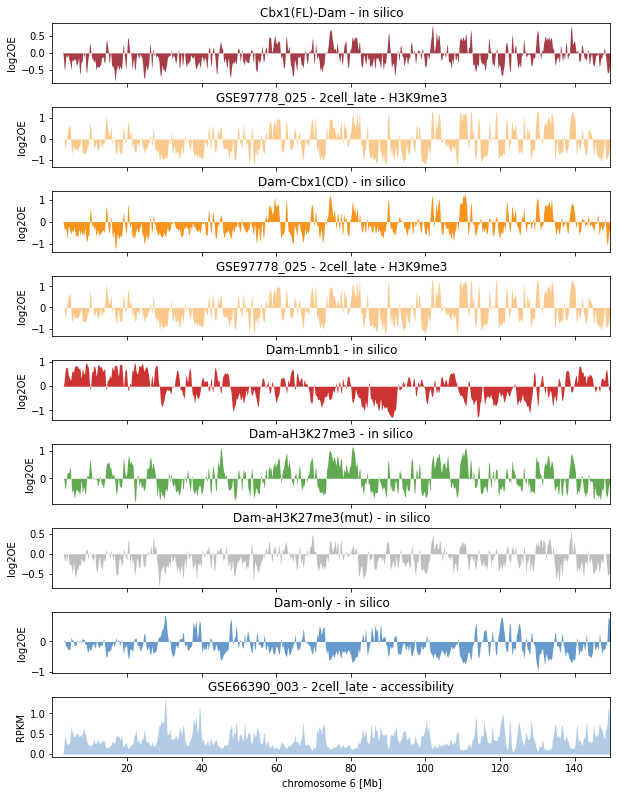

In [23]:
chrom = '6'
interval = []
smooth_std = 150000
figw = 10

to_plot_anno = anno.copy()
to_plot_ext = ext_anno.copy()

plot_genomic_region(to_plot_anno, to_plot_ext, chrom, interval, smooth_std, False, figw)

__Saving plots of selected regions__

In [24]:
regions_to_plot = [
    ['8', [80e6, 100e6], 40000, 5],
    ['12', [3e6, 20e6], 40000, 5],
    ['3', [65e6, 85e6], 40000, 5],
    ['3', [45e6, 55e6], 20000, 5],
    ['5', [50e6, 70e6], 40000, 5],
    ['5', [50e6, 60e6], 20000, 5]
]

In [25]:
to_plot_anno = anno.copy()
to_plot_ext = ext_anno.copy()

for chrom, interval, smooth_std, figw in regions_to_plot:
    plot_genomic_region(to_plot_anno, to_plot_ext, chrom, interval, smooth_std, False, figw)
    
    outfn = FIGOUTDIR + 'example_tracks.chr%s_%d_%d.binsize_%d.smooth_std_%d.pdf' % (chrom, int(interval[0]), int(interval[1]), BINSIZE, smooth_std)
    plt.savefig(outfn, bbox_inches='tight')
    plt.close()

# 4. Correlation with ChIP-seq

## 4.1 Hexbin with correlation

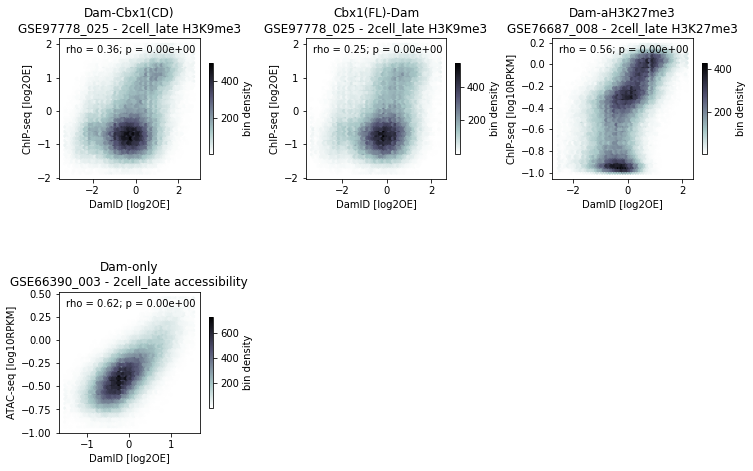

In [28]:
nplot = sum([(ext_anno.target == v).sum() for v in CONSTRUCT2TARGET.values()])
ncol = min(3, nplot)
nrow = int(np.ceil(nplot/ncol))

fig, axes = plt.subplots(nrow, ncol, figsize=(4*ncol, 4*nrow))
plt.subplots_adjust(hspace=.4, wspace=.4)
counter = 0

m_ind = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP
b_ind = ~np.concatenate([ext_data['blacklisted'][c] for c in chrom_order[:-2]])
filt_ind = m_ind&b_ind

for construct, target in CONSTRUCT2TARGET.items():
    for _, row in ext_anno[ext_anno.target==target].iterrows():
        
        ax = axes.flatten()[counter]
        counter += 1
        
        X = np.concatenate([insilico_pops['log2oe'][construct][c] for c in chrom_order[:-2]])[filt_ind]
        
        ext_sample = row['sample_id']
        control = row['control_id']
        Y = np.concatenate([ext_data['combined'][ext_sample][c] for c in chrom_order[:-2]])[filt_ind]
        if control != 'none':
            Yctrl = np.concatenate([ext_data['combined'][control][c] for c in chrom_order[:-2]])[filt_ind]
            Y = np.log2( (Y + PC) / (Yctrl + PC) )
            ylabel = '%s [log2OE]' % row['technique']
        else:
            Y  = np.log10(Y + PC)
            ylabel = '%s [log10RPKM]' % row['technique']
            
            
        yv = np.percentile(Y, [.1,99.9])
        xv = np.percentile(X, [.1,99.9])
        p = ax.hexbin(
            X.clip(xv[0], xv[1]), Y.clip(yv[0], yv[1]),
#             bins = 'log',
            mincnt=1, cmap='bone_r', gridsize=50
        )
        cbar = plt.colorbar(p, shrink=.5, ax=ax)
        cbar.ax.set_ylabel('bin density')
        
        # format
        t = '%s\n%s - %s %s' % (construct, ext_sample, row['stage'], target)
        ax.set_title(t)
        ax.set_box_aspect(1)
        
        ax.set_ylabel(ylabel)
        ax.set_xlabel('DamID [log2OE]')
        
        # correlation
        r, p = stats.spearmanr(X,Y)
        t = 'rho = %.2f; p = %.2e' % (r, p)
        ax.text(0.05, 0.95, t, va='top', ha='left', transform=ax.transAxes)
        
while counter < (nrow*ncol):
    axes.flatten()[counter].remove()
    counter += 1
    
outfn = FIGOUTDIR + 'correlation_with_ChIP.hexbin.binsize_%d.pdf' % BINSIZE
plt.savefig(outfn, bbox_inches='tight')

## 4.2 Correlation clustermap

In [29]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

In [31]:
# select good bins
m_ind = np.concatenate([mapab[c] for c in chrom_order[:-2]]) > MINMAP
b_ind = ~np.concatenate([ext_data['blacklisted'][c] for c in chrom_order[:-2]])
filt = m_ind & b_ind

to_plot = dict()

for construct in anno.fusion_construct.unique():
    
    if construct == 'Dam-2E12mut':
        continue
    
    ## collect damid data
    C = np.concatenate([insilico_pops['log2oe'][construct][c] for c in chrom_order[:-2]])
        
    to_plot['DamID_%s' % construct] = C[filt]
    
    ## collect external data
    if construct not in CONSTRUCT2TARGET:
        continue
    target = CONSTRUCT2TARGET[construct]
    for _, row in ext_anno[ext_anno.target==target].iterrows():

        ext_sample = row['sample_id']
        control = row['control_id']
        Y = np.concatenate([ext_data['combined'][ext_sample][c] for c in chrom_order[:-2]])
        if control != 'none':
            Yctrl = np.concatenate([ext_data['combined'][control][c] for c in chrom_order[:-2]])
            Y = np.log2( (Y + PC) / (Yctrl + PC) )
            ylabel = '%s [log2OE]' % row['technique']
        else:
            Y  = np.log10(Y + PC)
            ylabel = '%s [log10RPKM]' % row['technique']

        lab = '%s_%s_%s' % (row['technique'], row['target'], row['sample_id'])
        to_plot[lab] = Y[filt]
            
to_plot = pd.DataFrame(to_plot)

__All external/DamID samples vs all__

In [32]:
C = to_plot.corr(method='spearman')
linkage = hc.linkage(C, method='average')
order = hc.leaves_list(linkage)

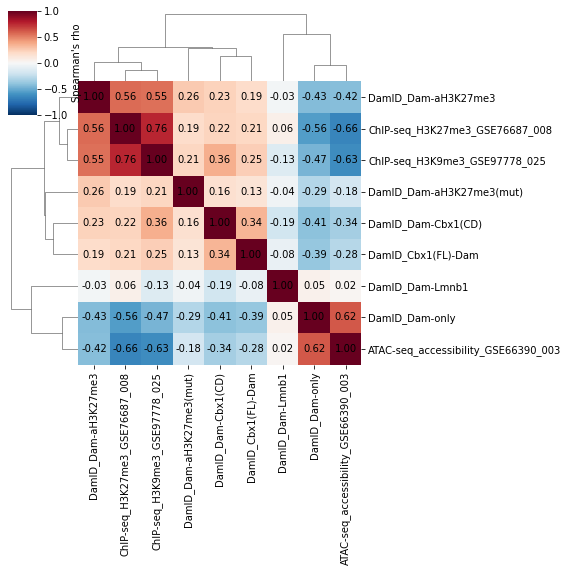

In [33]:
p = sns.clustermap(
    C, row_linkage=linkage, col_linkage=linkage, 
    cmap='RdBu_r', vmin=-1, vmax=1,
    figsize=(8,8)
)
p.ax_cbar.set_ylabel('Spearman\'s rho')

for i in range(len(C)):
    for j in range(len(C)):
        t = '%.2f' % C.iloc[order[i],order[j]]
        p.ax_heatmap.text(j+.5, i+.5, t, ha='center', va='center')

outfn = FIGOUTDIR + 'correlation_with_ChIP.clustermap.DamID_as_log2OE.all_vs_all.binsize_%d.pdf' % BINSIZE
plt.savefig(outfn, bbox_inches='tight')

__External samples vs DamID samples__

In [34]:
ind_select = C.columns.str.contains('DamID')
Cselect = C.loc[ind_select, ~ind_select].copy()
row_linkage = hc.linkage(Cselect, method='average')
row_order = hc.leaves_list(row_linkage)
col_linkage = hc.linkage(Cselect.T, method='average')
col_order = hc.leaves_list(col_linkage)

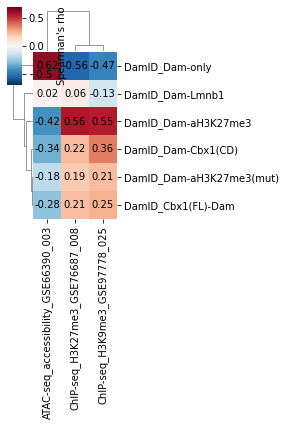

In [35]:
p = sns.clustermap(
    Cselect, row_linkage=row_linkage, col_linkage=col_linkage, 
    cmap='RdBu_r', vmin=-.7, vmax=.7,
    figsize=(4,6)
)
p.ax_cbar.set_ylabel('Spearman\'s rho')
p.ax_heatmap.set_aspect('equal')

for i in range(Cselect.shape[0]):
    for j in range(Cselect.shape[1]):
        
        t = '%.2f' % Cselect.iloc[row_order[i],col_order[j]]
        p.ax_heatmap.text(j+.5, i+.5, t, ha='center', va='center')

outfn = FIGOUTDIR + 'correlation_with_ChIP.clustermap.DamID_as_log2OE.DamID_vs_ChIP.binsize_%d.pdf' % BINSIZE
plt.savefig(outfn, bbox_inches='tight')